## Heston Calibration from yfinance + IV Surfaces (Calls & Puts)

This notebook:
- Télécharge les options d'un ticker via `yfinance` (calls & puts),
- calibre les paramètres de Heston sur les prix de calls, via PyTorch + `carr_madan_call_torch`,
- utilise ces paramètres calibrés pour construire une surface d'IV (Black-Scholes) en fonction de la moneyness `K/S0` et de la maturité `T`,
- trace une surface 3D pour les calls et une pour les puts.

In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import yfinance as yf

# Ajout du module Heston torch au path
import sys
root = Path.cwd()  # racine du projet
sys.path.append(str(root / 'Heston' / 'NN'))

from heston_torch import HestonParams, carr_madan_call_torch

torch.set_default_dtype(torch.float64)
device = torch.device('cpu')


In [2]:
def fetch_spot(symbol: str) -> float:
    ticker = yf.Ticker(symbol)
    hist = ticker.history(period='1d')
    if hist.empty:
        raise RuntimeError('Unable to retrieve spot price.')
    return float(hist['Close'].iloc[-1])

def _select_monthly_expirations(expirations, years_ahead: float = 3.0):
    today = pd.Timestamp.utcnow().date()
    limit_date = today + pd.Timedelta(days=365 * years_ahead)
    monthly = {}  # (year,month) -> (exp_ts, label)
    for exp in expirations:
        exp_ts = pd.Timestamp(exp)
        exp_date = exp_ts.date()
        if not (today < exp_date <= limit_date):
            continue
        key = (exp_date.year, exp_date.month)
        if key not in monthly or exp_ts < monthly[key][0]:
            monthly[key] = (exp_ts, exp)
    return [v[1] for v in sorted(monthly.values(), key=lambda x: x[0])]

def download_options(symbol: str, option_type: str, years_ahead: float = 3.0) -> pd.DataFrame:
    ticker = yf.Ticker(symbol)
    spot = fetch_spot(symbol)
    expirations = ticker.options
    if not expirations:
        raise RuntimeError(f'No option expirations found for {symbol}')
    selected = _select_monthly_expirations(expirations, years_ahead)
    rows = []
    now = pd.Timestamp.utcnow().tz_localize(None)
    for expiry in selected:
        expiry_dt = pd.Timestamp(expiry)
        T = max((expiry_dt - now).total_seconds() / (365.0 * 24 * 3600), 0.0)
        chain = ticker.option_chain(expiry)
        data = chain.calls if option_type == 'call' else chain.puts
        price_col = 'C_mkt' if option_type == 'call' else 'P_mkt'
        for _, row in data.iterrows():
            rows.append({'S0': spot, 'K': float(row['strike']), 'T': T, price_col: float(row['lastPrice'])})
    return pd.DataFrame(rows)

symbol = 'SPY'  # à adapter si besoin
calls_df = download_options(symbol, 'call')
puts_df = download_options(symbol, 'put')
len(calls_df), len(puts_df)


(1777, 1530)

In [3]:
# Préparation des tenseurs de calibration (calls uniquement)
df = calls_df[['S0', 'K', 'T', 'C_mkt']].dropna().copy()
n_total = len(df)
max_points = 300
if n_total > max_points:
    df = df.sort_values('T')
    idx = np.linspace(0, n_total - 1, max_points, dtype=int)
    df = df.iloc[idx]
df = df.reset_index(drop=True)
print(f'Calibration on {len(df)} call quotes (out of {n_total}).')
S0_t = torch.tensor(df['S0'].to_numpy(), dtype=torch.float64, device=device)
K_t = torch.tensor(df['K'].to_numpy(), dtype=torch.float64, device=device)
T_t = torch.tensor(df['T'].to_numpy(), dtype=torch.float64, device=device)
C_mkt_t = torch.tensor(df['C_mkt'].to_numpy(), dtype=torch.float64, device=device)
r = 0.02
q = 0.0


Calibration on 300 call quotes (out of 1777).


In [4]:
def prices_from_unconstrained(u: torch.Tensor) -> torch.Tensor:
    params = HestonParams.from_unconstrained(u[0], u[1], u[2], u[3], u[4])
    prices = []
    for S0_i, K_i, T_i in zip(S0_t, K_t, T_t):
        price_i = carr_madan_call_torch(S0_i, r, q, T_i, params, K_i)
        prices.append(price_i)
    return torch.stack(prices)

def loss(u: torch.Tensor) -> torch.Tensor:
    model_prices = prices_from_unconstrained(u)
    diff = model_prices - C_mkt_t
    return 0.5 * (diff ** 2).mean()


In [5]:
# Calibration par Adam
u = torch.tensor([1.0, -3.0, -0.5, -0.5, -3.0], dtype=torch.float64, device=device, requires_grad=True)
optimizer = torch.optim.Adam([u], lr=5e-3)
max_iters = 60
history = []
for it in range(max_iters):
    optimizer.zero_grad()
    L = loss(u)
    L.backward()
    optimizer.step()
    history.append(float(L.detach().cpu()))
    if it % 10 == 0:
        print(f'Iter {it:03d} | loss = {history[-1]:.6e}')
history[-5:]


Iter 000 | loss = 1.207238e+02
Iter 010 | loss = 1.188219e+02
Iter 020 | loss = 1.179297e+02
Iter 030 | loss = 1.170283e+02
Iter 040 | loss = 1.160927e+02
Iter 050 | loss = 1.152075e+02


[114.77352915141047,
 114.6878074744387,
 114.60252771473515,
 114.517713808819,
 114.43338176676592]

In [6]:
# Paramètres calibrés
with torch.no_grad():
    params_fin = HestonParams.from_unconstrained(u[0], u[1], u[2], u[3], u[4])
calib = {
    'kappa': float(params_fin.kappa.cpu()),
    'theta': float(params_fin.theta.cpu()),
    'sigma': float(params_fin.sigma.cpu()),
    'rho': float(params_fin.rho.cpu()),
    'v0'  : float(params_fin.v0.cpu()),
}
pd.Series(calib, name='Calibrated Heston parameters')


kappa    1.159946
theta    0.050115
sigma    0.571272
rho     -0.373200
v0       0.048386
Name: Calibrated Heston parameters, dtype: float64

In [7]:
# Conversion prix -> IV (Black-Scholes) sur grille (moneyness, T)
from math import erf

def bs_price(S0, K, T, vol, r):
    if T <= 0 or vol <= 0:
        return max(0.0, S0 - K * math.exp(-r * T))
    sqrt_T = math.sqrt(T)
    v = vol * sqrt_T
    d1 = (math.log(S0 / K) + (r + 0.5 * vol * vol) * T) / v
    d2 = d1 - v
    nd1 = 0.5 * (1.0 + erf(d1 / math.sqrt(2.0)))
    nd2 = 0.5 * (1.0 + erf(d2 / math.sqrt(2.0)))
    return S0 * nd1 - K * math.exp(-r * T) * nd2

def implied_vol(price, S0, K, T, r, tol=1e-6, max_iter=100):
    intrinsic = max(0.0, S0 - K * math.exp(-r * T))
    if price <= intrinsic + 1e-12:
        return 0.0
    low, high = 1e-6, 1.0
    p_high = bs_price(S0, K, T, high, r)
    while p_high < price and high < 5.0:
        high *= 2.0
        p_high = bs_price(S0, K, T, high, r)
    if p_high < price:
        return float('nan')
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        p_mid = bs_price(S0, K, T, mid, r)
        if abs(p_mid - price) < tol:
            return mid
        if p_mid > price:
            high = mid
        else:
            low = mid
    return 0.5 * (low + high)

S0_ref = float(calls_df['S0'].median())
T_grid = np.arange(0.1, 2.6, 0.1)
m_grid = np.linspace(0.8, 1.2, 21)
iv_call_surface = np.zeros((len(T_grid), len(m_grid)))
iv_put_surface = np.zeros_like(iv_call_surface)

with torch.no_grad():
    params_tensor = params_fin
    for i, T_val in enumerate(T_grid):
        K_vec = torch.tensor(S0_ref * m_grid, dtype=torch.float64, device=device)
        prices_call_t = carr_madan_call_torch(torch.tensor(S0_ref, dtype=torch.float64, device=device), r, 0.0, T_val, params_tensor, K_vec)
        prices_call = prices_call_t.cpu().numpy()
        for j, price_c in enumerate(prices_call):
            K_val = float(S0_ref * m_grid[j])
            iv_call_surface[i, j] = implied_vol(price_c, S0_ref, K_val, T_val, r)
            # Put via parité
            put_price = price_c - S0_ref + K_val * math.exp(-r * T_val)
            iv_put_surface[i, j] = implied_vol(put_price, S0_ref, K_val, T_val, r)
iv_call_surface[:3, :3]


array([[0.27813507, 0.2715285 , 0.26492717],
       [0.27325327, 0.26671376, 0.26016887],
       [0.26860477, 0.26214352, 0.25567657]])

/home/salok1/miniconda/envs/americanOption/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import gaussian_kde


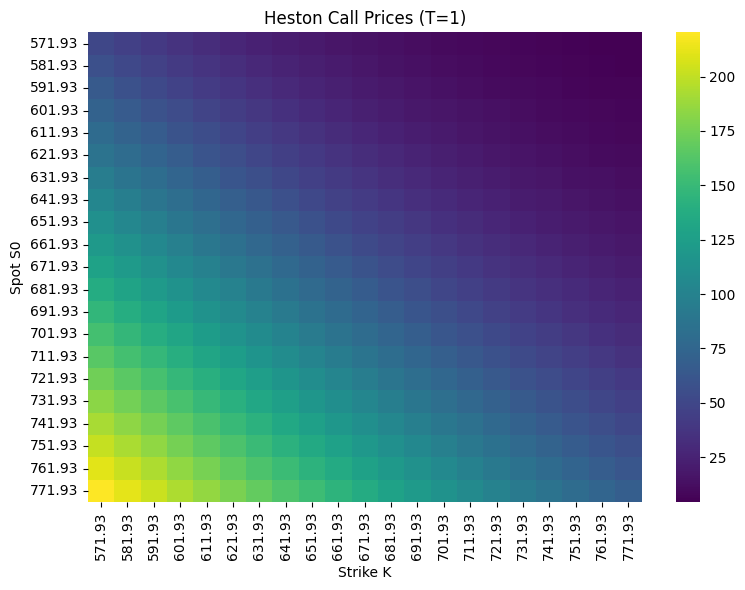

In [8]:
# Heatmap des prix Heston vs S et K pour T=1
import seaborn as sns
import matplotlib.pyplot as plt

S_grid = np.linspace(S0_ref - 100.0, S0_ref + 100.0, 21)
K_grid_prices = np.linspace(S0_ref - 100.0, S0_ref + 100.0, 21)
heatmap_prices = np.zeros((len(S_grid), len(K_grid_prices)))
T_fixed = 1.0

with torch.no_grad():
    params_tensor = params_fin
    for i, S_val in enumerate(S_grid):
        for j, K_val in enumerate(K_grid_prices):
            price = carr_madan_call_torch(
                torch.tensor(S_val, dtype=torch.float64, device=device),
                r,
                0.0,
                torch.tensor(T_fixed, dtype=torch.float64, device=device),
                params_tensor,
                torch.tensor(K_val, dtype=torch.float64, device=device),
            )
            heatmap_prices[i, j] = float(price.cpu())

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    heatmap_prices,
    xticklabels=np.round(K_grid_prices, 2),
    yticklabels=np.round(S_grid, 2),
    cmap='viridis',
    annot=False,
    ax=ax,
)
ax.set_xlabel('Strike K')
ax.set_ylabel('Spot S0')
ax.set_title('Heston Call Prices (T=1)')
plt.tight_layout()
plt.show()
